<span style="color:red; font-family:Helvetica Neue, Helvetica, Arial, sans-serif; font-size:2em;">An Exception was encountered at '<a href="#papermill-error-cell">In [13]</a>'.</span>

# East coast floods


In [1]:
import os
import datetime
import glob

from collections import Counter
import calendar
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import cartopy
import cartopy.crs as ccrs
import geopandas as gp
from IPython.display import Image
from scipy.stats import genextreme as gev
import xclim as xc
import cmocean
import seaborn as sns

from unseen import fileio
from unseen import general_utils
from unseen import time_utils
from unseen import indices

In [2]:
# Optional parameters 
# (This cell is tagged "parameters")
dpi = 300

In [3]:
# Parameters
agcd_file = "/g/data/xv83/dbi599/east-coast-rain/data/Rx15day_AGCD-CSIRO_r005_1900-2022_annual-aug-to-sep_east-coast-flood-region.zarr.zip"
model_file = "/g/data/xv83/dbi599/east-coast-rain/data/Rx15day_CAFE-c5-d60-pX-f6_19950501-20201101_annual-aug-to-sep_east-coast-flood-region.zarr.zip"
model_bc_file = "/g/data/xv83/dbi599/east-coast-rain/data/Rx15day_CAFE-c5-d60-pX-f6_19950501-20201101_annual-aug-to-sep_east-coast-flood-region_bias-corrected-AGCD-CSIRO-multiplicative.zarr.zip"
similarity_bc_file = "/g/data/xv83/dbi599/east-coast-rain/data/similarity-test_Rx15day_CAFE-c5-d60-pX-f6_1995-2020_annual-aug-to-sep_east-coast-flood-region_bias-corrected-AGCD-CSIRO-multiplicative.zarr.zip"
similarity_raw_file = "/g/data/xv83/dbi599/east-coast-rain/data/similarity-test_Rx15day_CAFE-c5-d60-pX-f6_1995-2020_annual-aug-to-sep_east-coast-flood-region_AGCD-CSIRO.zarr.zip"
independence_plot = "/g/data/xv83/dbi599/east-coast-rain/figures/independence-test_Rx15day_CAFE-c5-d60-pX-f6_19950501-20201101_annual-aug-to-sep_east-coast-flood-region.png"
model_name = "CAFE"
min_lead = 3
region_name = "east-coast-flood-region"
shape_file = "/g/data/xv83/dbi599/east-coast-rain/shapefiles/east-coast-flood.shp"
file_list = "file_lists/CAFE_c5-d60-pX-f6_pr_files.txt"
nino_file = "/g/data/xv83/dbi599/east-coast-rain/data/nino34-anomaly_CAFE-c5-d60-pX-f6_19950501-20201101_base-1995-2020.nc"


In [4]:
# Required parameters
assert 'model_name' in locals(), "Must provide a model name"
assert 'region_name' in locals(), "Must provide a region name"
assert 'min_lead' in locals(), "Must provide a minimum lead time"
assert os.path.isfile(file_list), "Must provide the input model files list (papermill option -p file_list [filepath])"
assert os.path.isfile(shape_file), "Must provide the shapefile (papermill option -p shape_file [filepath])"
assert os.path.isfile(agcd_file), "Must provide an AGCD data file (papermill option -p agcd_file [filepath])"
assert os.path.isfile(model_file), "Must provide an model data file (papermill option -p cafe_file [filepath])"
assert os.path.isfile(model_bc_file), "Must provide a model bias corrected data file (papermill option -p cafe_bc_file [filepath])"
assert os.path.isfile(nino_file), "Must provide a model Nino 3.4 data file (papermill option -p nino_file [filepath])"
assert os.path.isfile(similarity_bc_file), "Must provide an bias corrected similarity test file (papermill option -p similarity_bias_file [filepath])"
assert os.path.isfile(similarity_raw_file), "Must provide an raw data similarity test file (papermill option -p similarity_raw_file [filepath])"
assert os.path.isfile(independence_plot), "Must provide an independence test plot (papermill option -p independence_plot [filepath])"

## Observations

In [5]:
agcd_ds = fileio.open_dataset(agcd_file)
agcd_ds = agcd_ds.dropna('time')

In [6]:
agcd_ds

<xarray.Dataset>
Dimensions:     (time: 122)
Coordinates:
    event_time  (time) <U28 dask.array<chunksize=(122,), meta=np.ndarray>
  * time        (time) object 1901-01-01 09:00:00 ... 2022-01-01 09:00:00
Data variables:
    pr          (time) float32 dask.array<chunksize=(1,), meta=np.ndarray>
Attributes: (12/33)
    CDI:                           Climate Data Interface version ?? (http://...
    CDO:                           Climate Data Operators version 1.7.0 (http...
    Conventions:                   CF-1.6
    acknowledgment:                The Australian Government, Bureau of Meteo...
    analysis_components:           total: the gridded accumulation of rainfall.
    bom-cmp-awap_version:          bom-cmp-awap-1.00-89.0.x86_64
    ...                            ...
    summary:                       The daily and monthly rainfall data repres...
    time_coverage_end:             1900-01-01T09:00:00
    time_coverage_start:           1899-12-31T09:00:00
    title:                         Interpolated Rain Gauge Precipitation
    url:                           http://www.bom.gov.au/climate/
    uuid:                          14333ae2-28fe-4cb6-9f00-677adc94f25e

In [7]:
years = agcd_ds['time'].dt.year.values
agcd_df = pd.DataFrame(index=years)
agcd_df['pr'] = agcd_ds['pr'].values

In [8]:
pr2022 = agcd_ds['pr'].values.max()
print(pr2022)

410.43057


## Model ensemble

### Region selection

In [9]:
with open(file_list) as f:
    all_files = f.read()
    first_file = all_files.split('\n', 1)[0]

In [10]:
first_file

'/g/data/xv83/dcfp/CAFE-f6/c5-d60-pX-f6-19950501/atmos_isobaric_daily.zarr.zip'

In [11]:
shapes = gp.read_file(shape_file)

In [12]:
isel_dict = {'time': 0}
if model_name == 'CAFE':
    isel_dict['ensemble'] = 0
    metadata_file = '/home/599/dbi599/unseen/config/dataset_cafe_daily.yml'
else:
    metadata_file = None

<span id="papermill-error-cell" style="color:red; font-family:Helvetica Neue, Helvetica, Arial, sans-serif; font-size:2em;">Execution using papermill encountered an exception here and stopped:</span>

In [13]:
region_ds = fileio.open_dataset(
    first_file,
    metadata_file=metadata_file,
    variables=['pr'],
    lat_bnds=[-40, -20],
    lon_bnds=[140, 160],
    shapefile=shape_file,
    shape_overlap=0.1,
    units={'pr': 'mm day-1'},
    isel=isel_dict,
)

DimensionalityError: Cannot convert from 'kilogram / meter ** 2 / second' ([mass] / [length] ** 2 / [time]) to 'millimeter / day' ([length] / [time])

In [ ]:
fig = plt.figure(figsize=[12,8])
ax = fig.add_subplot(111, projection=ccrs.PlateCarree())
region_ds['pr'].plot(
    ax=ax,
    transform=ccrs.PlateCarree(),
    cmap='viridis_r',
)
ax.coastlines()
ax.add_feature(cartopy.feature.STATES)
ax.add_geometries(shapes.geometry, ccrs.PlateCarree(), facecolor='none', edgecolor='orange')
plt.show()

### Model data

In [13]:
model_ds = fileio.open_dataset(model_file)
model_bc_ds = fileio.open_dataset(model_bc_file)

In [14]:
model_ds

<xarray.Dataset>
Dimensions:     (ensemble: 96, init_date: 52, lead_time: 11)
Coordinates:
  * ensemble    (ensemble) int64 1 2 3 4 5 6 7 8 9 ... 89 90 91 92 93 94 95 96
    event_time  (init_date, lead_time, ensemble) <U28 dask.array<chunksize=(52, 11, 96), meta=np.ndarray>
  * init_date   (init_date) object 1995-05-01 00:00:00 ... 2020-11-01 00:00:00
  * lead_time   (lead_time) int64 0 1 2 3 4 5 6 7 8 9 10
    time        (lead_time, init_date) object dask.array<chunksize=(11, 52), meta=np.ndarray>
Data variables:
    pr          (init_date, lead_time, ensemble) float64 dask.array<chunksize=(1, 11, 96), meta=np.ndarray>
Attributes:
    comment:    pressure level interpolator, version 3.0, precision=double
    filename:   atmos_isobaric_daily.zarr
    grid_tile:  N/A
    grid_type:  regular
    history:    Thu Jan 05 08:55:25 2023: /g/data/xv83/dbi599/miniconda3/envs...
    title:      AccessOcean-AM2

### Independence testing

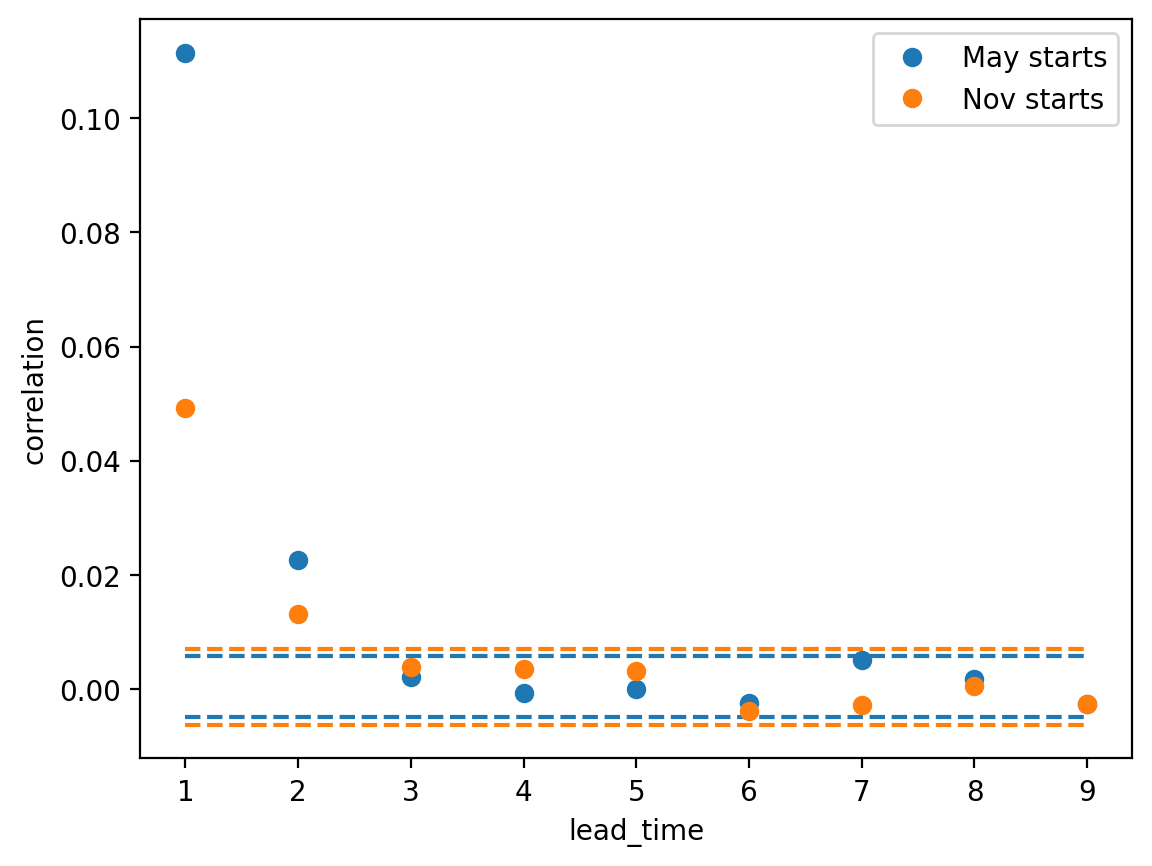

In [15]:
Image(filename=independence_plot)

In [16]:
print(min_lead)

3


In [17]:
model_da = model_ds['pr'].where(model_ds['lead_time'] >= min_lead)

In [18]:
model_da_stacked = model_da.dropna('lead_time').stack({'sample': ['ensemble', 'init_date', 'lead_time']})

In [19]:
model_da_stacked.shape

(34944,)

In [20]:
model_bc_da_stacked = model_bc_ds.dropna('lead_time')['pr'].stack({'sample': ['ensemble', 'init_date', 'lead_time']})

In [21]:
model_bc_da_stacked.shape

(34944,)

### Bias correction and similarity testing

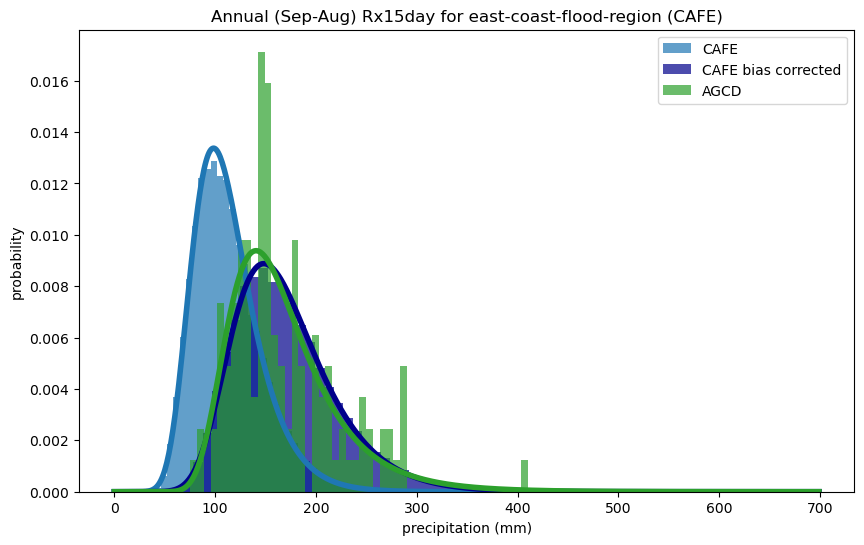

In [22]:
fig = plt.figure(figsize=[10, 6])
gev_xvals = np.arange(0, 700)

model_da.plot.hist(
    bins=50, density=True, label=model_name, alpha=0.7, facecolor='tab:blue',
)
model_gev_shape, model_gev_loc, model_gev_scale = indices.fit_gev(model_da_stacked.values)
model_gev_pdf = gev.pdf(gev_xvals, model_gev_shape, model_gev_loc, model_gev_scale)
plt.plot(gev_xvals, model_gev_pdf, color='tab:blue', linewidth=4.0)

model_bc_ds['pr'].plot.hist(
    bins=50, density=True, label=f'{model_name} bias corrected', facecolor='darkblue', alpha=0.7
)
model_bc_gev_shape, model_bc_gev_loc, model_bc_gev_scale = indices.fit_gev(model_bc_da_stacked.values)
model_bc_gev_pdf = gev.pdf(gev_xvals, model_bc_gev_shape, model_bc_gev_loc, model_bc_gev_scale)
plt.plot(gev_xvals, model_bc_gev_pdf, color='darkblue', linewidth=4.0)

agcd_ds['pr'].plot.hist(
    bins=50, density=True, label='AGCD', facecolor='tab:green', alpha=0.7
)
agcd_gev_shape, agcd_gev_loc, agcd_gev_scale = indices.fit_gev(agcd_ds['pr'].values)
agcd_gev_pdf = gev.pdf(gev_xvals, agcd_gev_shape, agcd_gev_loc, agcd_gev_scale)
plt.plot(gev_xvals, agcd_gev_pdf, color='tab:green', linewidth=4.0)

plt.xlabel('precipitation (mm)')
plt.ylabel('probability')
plt.title(f'Annual (Sep-Aug) Rx15day for {region_name} ({model_name})')
plt.legend()
plt.savefig(f'/g/data/xv83/dbi599/east-coast-rain/figures/Rx15day_histogram_{model_name}_{region_name}.png',
            bbox_inches='tight', facecolor='white', dpi=dpi)
plt.show()

We can look at p-values for the KS-test and Anderson-Darling test for each lead time.

p > 0.05 means the null hypothesis (that the two samples are from the same population) can't be rejected.

In [23]:
similarity_raw_ds = fileio.open_dataset(similarity_raw_file)

In [24]:
similarity_raw_ds['ks_pval'].values

array([4.5100378e-06, 2.2608257e-09, 3.1694092e-10, 2.0319471e-09,
       1.8449137e-08, 1.7187098e-08, 1.4488616e-08, 1.8449137e-08,
       1.6237811e-08], dtype=float32)

In [25]:
similarity_raw_ds['ad_pval'].values

array([0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001],
      dtype=float32)

In [26]:
similarity_bias_ds = fileio.open_dataset(similarity_bc_file)

In [27]:
similarity_bias_ds['ks_pval'].values

array([0.890162  , 0.706683  , 0.6635799 , 0.6549238 , 0.74901956,
       0.51892614, 0.575773  ], dtype=float32)

In [28]:
similarity_bias_ds['ad_pval'].values

array([0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25], dtype=float32)

### Exceedance curves

In [29]:
def plot_exceedance(sample_ds, model_name, outfile=None):
    """Plot single exceedance curve"""
    
    sorted_data, exceedance_data = general_utils.exceedance_curve(sample_ds)
    
    fig = plt.figure(figsize=[8, 6])
    ax = fig.add_subplot()
    ax.plot(sorted_data, exceedance_data)
    ax.set_title(f'Annual (Sep-Aug) Rx15day for {region_name} ({model_name})')
    ax.set_ylabel('likelihood of exceedance (%)')
    ax.set_xlabel('Rx15day precipitation (mm)')
    ax.axvline(pr2022, color='0.5', linestyle='--')
    if outfile:
        plt.savefig(outfile, bbox_inches='tight', facecolor='white', dpi=dpi)
        print(outfile)
    else:
        plt.show()

In [30]:
def gev_event_likelihood(event, shape, loc, scale):
    """Get likelihood stats for an event from a GEV fit"""

    probability = gev.sf(event, shape, loc=loc, scale=scale)
    return_period = 1. / probability
    percentile = (1 - probability) * 100
    print(f'{percentile:.2f}% percentile')
    print(f'{return_period:.0f} year return period\n')

In [31]:
def plot_exceedance_by_decade(sample_ds, model_name):
    """Plot exceedance curve by decade"""

    fig = plt.figure(figsize=[8, 6])
    ax = fig.add_subplot()
    if model_name == 'CAFE':
        start_years = [1995, 2000, 2005, 2010, 2015]
        step = 4
    else:
        start_years = [1960, 1970, 1980, 1990, 2000, 2010]
        step = 9
    colors = iter(plt.cm.hot_r(np.linspace(0.3, 1, len(start_years))))

    for start_year in start_years:
        end_year = start_year + step
        start_date = f'{start_year}-01-01'
        end_date = f'{end_year}-12-25'
        ds_selection = time_utils.select_time_period(sample_ds, [start_date, end_date])
        ds_selection = ds_selection.dropna('sample')
        sorted_data, exceedance_data = general_utils.exceedance_curve(ds_selection)
        n_years = len(sorted_data)
        label = f'{start_year}-{end_year} ({n_years} samples)'
        color = next(colors)
        ax.plot(sorted_data, exceedance_data, label=label, color=color)
    
        print(f'{start_year}-{end_year}')
        n_events, n_population, return_period, percentile = general_utils.event_in_context(ds_selection.values, pr2022, 'above')
        print(f'{n_events} events in {n_population} samples')
        print(f'{percentile:.2f}% percentile')
        print(f'{return_period:.0f} year return period')
        print('GEV:')
        gev_shape, gev_loc, gev_scale = indices.fit_gev(ds_selection.values)
        gev_event_likelihood(pr2022, gev_shape, gev_loc, gev_scale)

    ax.set_title(f'Annual (Sep-Aug) Rx15day for {region_name} ({model_name})')
    ax.set_ylabel('likelihood of exceedance (%)')
    ax.set_xlabel('Rx15day precipitation (mm)')
    ax.legend()
    ax.axvline(pr2022, color='0.5', linestyle='--')
    outfile = f'/g/data/xv83/dbi599/east-coast-rain/figures/Rx15day_precip_exceedence_{region_name}_{model_name}_by-decade.png'
    plt.savefig(outfile, bbox_inches='tight', facecolor='white', dpi=dpi)
    print(outfile)

#### Bias corrected data

/g/data/xv83/dbi599/east-coast-rain/figures/Rx15day_precip_exceedence_east-coast-flood-region_CAFE.png


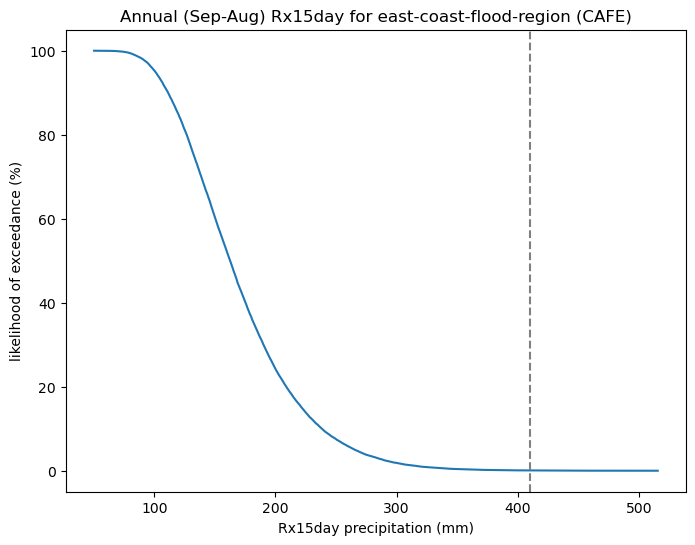

In [32]:
outfile = f'/g/data/xv83/dbi599/east-coast-rain/figures/Rx15day_precip_exceedence_{region_name}_{model_name}.png'
plot_exceedance(model_bc_da_stacked, model_name, outfile=outfile)

In [33]:
n_events_bc, n_population_bc, return_period_bc, percentile_bc = general_utils.event_in_context(model_bc_da_stacked.values, pr2022, 'above')
print('BIAS CORRECTED DATA')
print(f'{n_events_bc} events in {n_population_bc} samples')
print(f'{percentile_bc:.2f}% percentile')
print(f'{return_period_bc:.0f} year return period')

BIAS CORRECTED DATA
23 events in 34944 samples
99.93% percentile
1519 year return period


In [34]:
print('BIAS CORRECTED GEV')
gev_event_likelihood(pr2022, model_bc_gev_shape, model_bc_gev_loc, model_bc_gev_scale)

BIAS CORRECTED GEV
99.91% percentile
1114 year return period



1995-1999
0 events in 576 samples
100.00% percentile
inf year return period
GEV:


/home/599/dbi599/unseen/unseen/general_utils.py:151: RuntimeWarning: divide by zero encountered in long_scalars
  return_period = n_population / n_events


99.94% percentile
1621 year return period

2000-2004
2 events in 4800 samples
99.96% percentile
2400 year return period
GEV:
97.10% percentile
35 year return period

2005-2009
5 events in 6720 samples
99.93% percentile
1344 year return period
GEV:
99.88% percentile
853 year return period

2010-2014
6 events in 6720 samples
99.91% percentile
1120 year return period
GEV:
99.93% percentile
1430 year return period

2015-2019
4 events in 6720 samples
99.94% percentile
1680 year return period
GEV:
99.91% percentile
1132 year return period

/g/data/xv83/dbi599/east-coast-rain/figures/Rx15day_precip_exceedence_east-coast-flood-region_CAFE_by-decade.png


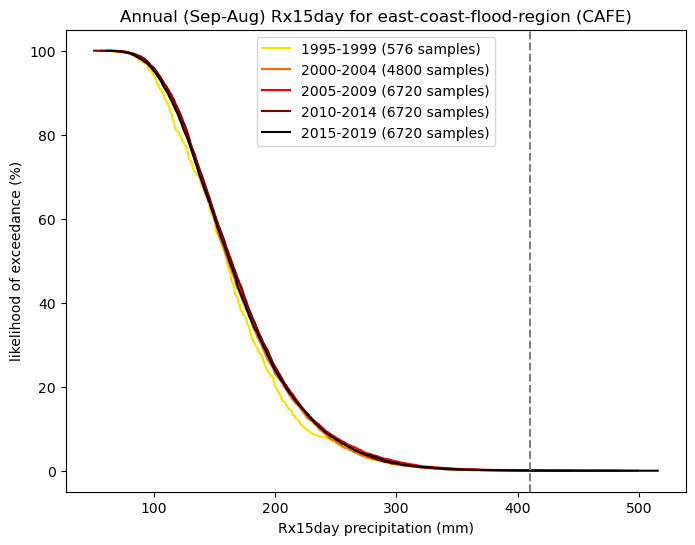

In [35]:
plot_exceedance_by_decade(model_bc_da_stacked, model_name)

#### Raw data

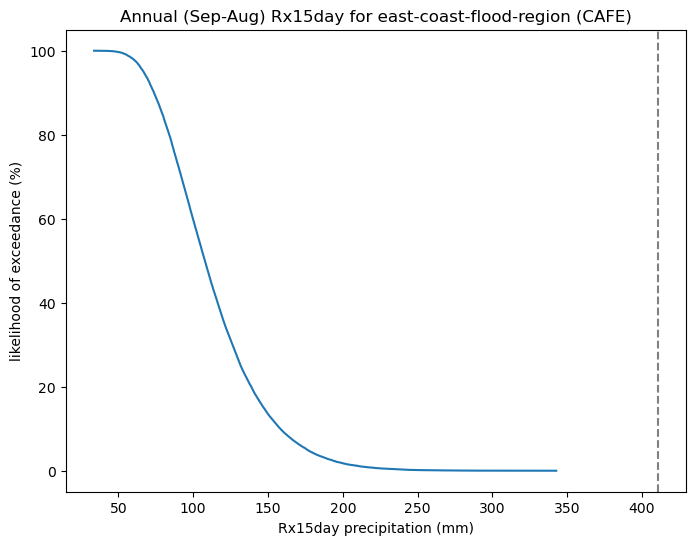

In [36]:
plot_exceedance(model_da_stacked, model_name)

In [37]:
n_events, n_population, return_period, percentile = general_utils.event_in_context(model_da_stacked.values, pr2022, 'above')
print('RAW DATA')
print(f'{n_events} events in {n_population} samples')
print(f'{percentile:.2f}% percentile')
print(f'{return_period:.0f} year return period')

RAW DATA
0 events in 34944 samples
100.00% percentile
inf year return period


/home/599/dbi599/unseen/unseen/general_utils.py:151: RuntimeWarning: divide by zero encountered in long_scalars
  return_period = n_population / n_events


In [38]:
print('RAW GEV')
gev_event_likelihood(pr2022, model_gev_shape, model_gev_loc, model_gev_scale)

RAW GEV
100.00% percentile
944123 year return period



### Seasonality

In [39]:
model_df = model_da_stacked.to_dataframe()
model_df = model_df.dropna()
#model_df = model_df.reset_index()
model_df

event_time                 time  \
ensemble init_date           lead_time                                    
1        1995-05-01 00:00:00 3          1998-03-22  1998-05-01 12:00:00   
                             4          1999-01-25  1999-05-01 12:00:00   
                             5          2000-01-07  2000-05-01 12:00:00   
                             6          2001-06-26  2001-05-01 12:00:00   
                             7          2001-11-21  2002-05-01 12:00:00   
...                                            ...                  ...   
96       2020-11-01 00:00:00 5          2026-02-11  2025-11-01 12:00:00   
                             6          2027-01-30  2026-11-01 12:00:00   
                             7          2028-06-11  2027-11-02 12:00:00   
                             8          2029-06-10  2028-11-01 12:00:00   
                             9          2030-03-22  2029-11-01 12:00:00   

                                        ensemble            init_date  \
ensemble init_date           lead_time                                  
1        1995-05-01 00:00:00 3                 1  1995-05-01 00:00:00   
                             4                 1  1995-05-01 00:00:00   
                             5                 1  1995-05-01 00:00:00   
                             6                 1  1995-05-01 00:00:00   
                             7                 1  1995-05-01 00:00:00   
...                                          ...                  ...   
96       2020-11-01 00:00:00 5                96  2020-11-01 00:00:00   
                             6                96  2020-11-01 00:00:00   
                             7                96  2020-11-01 00:00:00   
                             8                96  2020-11-01 00:00:00   
                             9                96  2020-11-01 00:00:00   

                                        lead_time          pr  
ensemble init_date           lead_time                         
1        1995-05-01 00:00:00 3                  3   85.326740  
                             4                  4  192.782426  
                             5                  5  116.079985  
                             6                  6  112.088088  
                             7                  7   91.687020  
...                                           ...         ...  
96       2020-11-01 00:00:00 5                  5  101.403751  
                             6                  6   91.169808  
                             7                  7  101.765210  
                             8                  8   90.422414  
                             9                  9  218.817521  

[34944 rows x 6 columns]

In [40]:
event_months = [int(date[5:7]) for date in model_df['event_time'].values]
event_years = [int(date[0:4]) for date in model_df['event_time'].values]

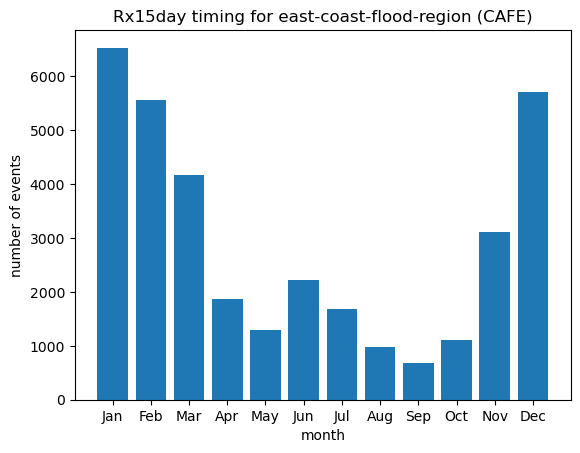

In [41]:
month_counts = Counter(event_months)
months = np.arange(1, 13)
counts = [month_counts[month] for month in months]

plt.bar(months, counts)
plt.title(f'Rx15day timing for {region_name} ({model_name})')
plt.ylabel('number of events')
plt.xlabel('month')
xlabels = [calendar.month_abbr[i] for i in months]
plt.xticks(months, xlabels)
#plt.savefig(
#    f'/g/data/xv83/dbi599/east-coast-rain/figures/Rx15day_timing_AGCD_{region_name}.png',
#    bbox_inches='tight',
#    facecolor='white',
#    dpi=dpi
#)
plt.show()

### Relationship with ENSO

In [42]:
nino_ds = fileio.open_dataset(nino_file)
nino_ds = nino_ds.assign_coords({'init_date': [date.strftime('%Y%m') for date in nino_ds['init_date'].values]})
nino_ds

<xarray.Dataset>
Dimensions:    (init_date: 52, lead_time: 120, ensemble: 96)
Coordinates:
  * ensemble   (ensemble) int64 1 2 3 4 5 6 7 8 9 ... 88 89 90 91 92 93 94 95 96
  * lead_time  (lead_time) int64 0 1 2 3 4 5 6 7 ... 113 114 115 116 117 118 119
  * init_date  (init_date) <U6 '199505' '199511' '199605' ... '202005' '202011'
    time       (lead_time, init_date) object dask.array<chunksize=(120, 52), meta=np.ndarray>
Data variables:
    tos        (init_date, lead_time, ensemble) float32 dask.array<chunksize=(52, 120, 96), meta=np.ndarray>
Attributes:
    history:  Fri Mar 03 08:03:37 2023: /g/data/xv83/dbi599/miniconda3/envs/u...

In [43]:
nino_values = []
for index, row in model_df.iterrows():
    event_init_date = row['init_date'].strftime('%Y%m')
    event_ensemble = row['ensemble']
    event_year_month = row['time'].strftime('%Y-%m')
    nino_selection = nino_ds.sel({'init_date': event_init_date, 'ensemble': event_ensemble})
    nino_selection = nino_selection.swap_dims({'lead_time': 'time'})
    nino_year_month = [date.strftime('%Y-%m') for date in nino_selection['time'].values]
    nino_selection = nino_selection.assign_coords({'time': nino_year_month})
    nino_value = float(nino_selection['tos'].sel({'time': event_year_month}).values)
    nino_values.append(nino_value)

In [44]:
model_df['nino34'] = nino_values

/g/data/xv83/dbi599/miniconda3/envs/unseen/lib/python3.9/site-packages/seaborn/distributions.py:1185: UserWarning: The following kwargs were not used by contour: 'linewidth'
  cset = contour_func(


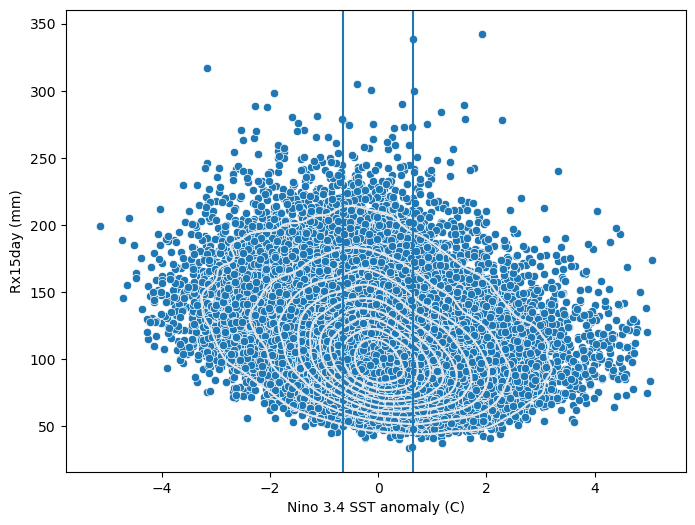

In [45]:
fig = plt.figure(figsize=[8, 6])
ax = fig.add_subplot(111)

sns.scatterplot(ax=ax, data=model_df, x='nino34', y='pr')
sns.kdeplot(ax=ax, data=model_df, x='nino34', y='pr', color='0.9', linewidth=1)

ax.set_ylabel('Rx15day (mm)')
ax.set_xlabel('Nino 3.4 SST anomaly (C)')
ax.axvline(0.65)
ax.axvline(-0.65)
plt.show()

### Meteorology

In [46]:
def plot_average(start_date, end_date, color_da=None, color_var=None, contour_da=None, contour_var=None):
    """Plot average"""
    
    fig = plt.figure(figsize=[10, 5])
    map_proj=ccrs.PlateCarree(central_longitude=180)
    ax1 = fig.add_subplot(1, 1, 1, projection=map_proj)       
    
    if color_var:
        if color_var == 'pr':
            levels = [0, 100, 200, 300, 400, 500, 600, 700, 800]
            label = 'total precipitation (mm)'
            cmap = cmocean.cm.rain
            extend = 'max'
        elif color_var == 'ua300':
            levels = [-30, -25, -20, -15, -10, -5, 0, 5, 10, 15, 20, 25, 30]
            label = '300hPa zonal wind'
            cmap='RdBu_r'
            extend = 'both'
        else:
            raise ValueError('Invalid color variable')
        color_da.plot(
            ax=ax1,
            transform=ccrs.PlateCarree(),
            cmap=cmap,
            levels=levels,
            extend=extend,
            cbar_kwargs={'label': label},
        )
    
    if contour_var:
        if contour_var == 'z500':
            levels = np.arange(5000, 6300, 50)
        elif contour_var == 'psl':
            levels = np.arange(900, 1100, 2.5)
        elif contour_var == 'ua300':
            levels = np.arange(15, 60, 5)
        else:
            raise ValueError('Invalid contour variable')
        lines = contour_da.plot.contour(
            ax=ax1,
            transform=ccrs.PlateCarree(),
            levels=levels,
            colors=['0.1']
        )
        ax1.clabel(lines, colors=['0.1'], manual=False, inline=True)
    
    ax1.coastlines()
    ax1.set_extent([90, 205, -55, 10], crs=ccrs.PlateCarree())
    ax1.gridlines(linestyle='--', draw_labels=True)
    if contour_var:
        ax1.set_title(f'Average {contour_var} ({contour_da.units}), {start_date} to {end_date}')
    else:
        ax1.set_title(f'{start_date} to {end_date}')
#    plt.savefig(
#        f'/home/599/dbi599/east-coast-rain/{color_var}-{contour_var}_mean_BARRA2_{start_date}_{end_date}.png',
#        bbox_inches='tight',
#        facecolor='white',
#        dpi=300
#    )
    plt.show()

In [47]:
ranked_events = model_df.sort_values(by=['pr'], ascending=False)
ranked_events.head(n=10)

,,,event_time,time,ensemble,init_date,lead_time,pr,nino34
ensemble,init_date,lead_time,,,,,,,
30,2011-11-01 00:00:00,4,2016-02-17,2015-11-01 12:00:00,30,2011-11-01 00:00:00,4,342.611730,1.919794
85,2000-05-01 00:00:00,7,2007-03-13,2007-05-01 12:00:00,85,2000-05-01 00:00:00,7,338.352156,0.643784
60,2004-11-01 00:00:00,9,2014-03-25,2013-11-01 12:00:00,60,2004-11-01 00:00:00,9,316.928423,-3.158852
80,1999-05-01 00:00:00,6,2004-12-21,2005-05-01 12:00:00,80,1999-05-01 00:00:00,6,305.218342,-0.395113
37,2018-05-01 00:00:00,6,2024-02-12,2024-05-01 12:00:00,37,2018-05-01 00:00:00,6,300.254011,-0.136169
23,2011-05-01 00:00:00,9,2020-02-01,2020-05-01 12:00:00,23,2011-05-01 00:00:00,9,300.038223,0.655939
5,1995-05-01 00:00:00,5,2000-01-09,2000-05-01 12:00:00,5,1995-05-01 00:00:00,5,298.074731,-1.926889
93,2019-05-01 00:00:00,8,2027-02-17,2027-05-01 12:00:00,93,2019-05-01 00:00:00,8,290.401339,0.438513
59,2013-11-01 00:00:00,8,2022-03-03,2021-11-01 12:00:00,59,2013-11-01 00:00:00,8,289.505622,1.583517


In [48]:
model_bc_df = model_bc_ds['pr'].to_dataframe()
model_bc_df = model_bc_df.dropna()
model_bc_df = model_bc_df.reset_index()
ranked_bc_events = model_bc_df.sort_values(by=['pr'], ascending=False)
ranked_bc_events.head(n=10)

,init_date,lead_time,ensemble,event_time,time,pr
22301,2011-11-01 00:00:00,4,30,2016-02-17,2015-11-01 12:00:00,515.651429
7188,2000-05-01 00:00:00,7,85,2007-03-13,2007-05-01 12:00:00,498.802202
13403,2004-11-01 00:00:00,9,60,2014-03-25,2013-11-01 12:00:00,483.364569
5743,1999-05-01 00:00:00,6,80,2004-12-21,2005-05-01 12:00:00,459.509215
22102,2011-05-01 00:00:00,9,23,2020-02-01,2020-05-01 12:00:00,453.210301
31236,2018-05-01 00:00:00,6,37,2024-02-12,2024-05-01 12:00:00,452.035365
196,1995-05-01 00:00:00,5,5,2000-01-09,2000-05-01 12:00:00,444.784249
32828,2019-05-01 00:00:00,8,93,2027-02-17,2027-05-01 12:00:00,440.972969
25402,2013-11-01 00:00:00,8,59,2022-03-03,2021-11-01 12:00:00,435.080435
23708,2012-11-01 00:00:00,4,93,2017-02-13,2016-11-01 12:00:00,433.184236


In [ ]:
for index, row in ranked_events.head(n=4).iterrows():
    init_date = row['init_date'].strftime('%Y%m%d')
    ensemble = row['ensemble']
    end_date = row['event_time']
    rx_value = row['pr']
    print(f'{init_date} ({end_date}), ensemble:{ensemble}, {rx_value}mm')
        
    atmos_file = f'/g/data/xv83/dcfp/CAFE-f6/c5-d60-pX-f6-{init_date}/atmos_isobaric_daily.zarr.zip'
    atmos_ds = fileio.open_dataset(
        atmos_file,
        metadata_file='/home/599/dbi599/unseen/config/dataset_cafe_daily.yml',
        variables=['h500', 'slp', 'pr', 'ucomp'],
    )
    start_datetime = datetime.datetime.strptime(end_date, "%Y-%m-%d") - datetime.timedelta(days=14)
    start_date = start_datetime.strftime("%Y-%m-%d")
    z500_da = atmos_ds.sel({'ensemble': ensemble, 'time': slice(start_date, end_date)})['h500']
    pr_da = atmos_ds.sel({'ensemble': ensemble, 'time': slice(start_date, end_date)})['pr']
    pr_da = xc.units.convert_units_to(pr_da, 'mm d-1')
    psl_da = atmos_ds.sel({'ensemble': ensemble, 'time': slice(start_date, end_date)})['slp']
    ua300_da = atmos_ds.sel({'ensemble': ensemble, 'level': 300, 'time': slice(start_date, end_date)})['ucomp']

    z500_da_mean = z500_da.mean('time', keep_attrs=True)
    pr_da_sum = pr_da.sum('time', keep_attrs=True)
    psl_da_mean = psl_da.mean('time', keep_attrs=True)
    ua300_da_mean = ua300_da.mean('time', keep_attrs=True) 

    plot_average(pr_da_sum, 'pr', z500_da_mean, 'z500', start_date, end_date)
    plot_average(pr_da_sum, 'pr', psl_da_mean, 'psl', start_date, end_date)
    plot_average(ua300_da_mean, 'ua300', z500_da_mean, 'z500', start_date, end_date)